In [1]:
!pip install pandas nltk transformers vaderSentiment torch
!pip install vaderSentiment
!pip install transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
# Import required libraries
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
import matplotlib.pyplot as plt
from google.colab import files
import torch
from multiprocessing import Pool

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
uploaded = files.upload()

Saving twitter_training.csv to twitter_training.csv
Saving twitter_validation.csv to twitter_validation.csv


In [5]:
train_data = pd.read_csv('twitter_training.csv')
validation_data = pd.read_csv('twitter_validation.csv')

In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if not w.lower() in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return ' '.join(tokens)

train_data['cleaned_Positive'] = train_data['Positive'].apply(preprocess)
validation_data['cleaned_Irrelevant'] = validation_data['Irrelevant'].apply(preprocess)

In [7]:
vader_analyzer = SentimentIntensityAnalyzer()

In [8]:
def vader_sentiment(text):
    return vader_analyzer.polarity_scores(text)['compound']

train_data['vader_compound'] = train_data['cleaned_Positive'].apply(vader_sentiment)
validation_data['vader_compound'] = validation_data['cleaned_Irrelevant'].apply(vader_sentiment)

In [13]:
bert_analyzer = pipeline('sentiment-analysis', model="distilbert-base-uncased-finetuned-sst-2-english", device=0 if torch.cuda.is_available() else -1)

def bert_sentiment(text):
    result = bert_analyzer(text)[0]
    return result['label'], result['score']

def apply_bert_sentiment(df):
    # Use 'cleaned_Positive' for train_data, 'cleaned_Irrelevant' for validation_data
    column_name = 'cleaned_Positive' if 'cleaned_Positive' in df.columns else 'cleaned_Irrelevant'
    df[['bert_label', 'bert_score']] = df[column_name].apply(lambda x: pd.Series(bert_sentiment(x)))
    return df

In [14]:
with Pool() as pool:
    train_data = pool.apply(apply_bert_sentiment, (train_data,))
    validation_data = pool.apply(apply_bert_sentiment, (validation_data,))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


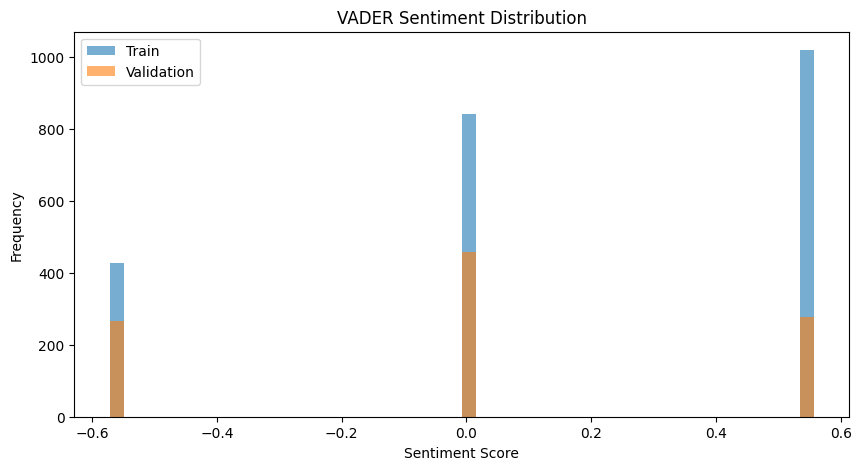

In [15]:
plt.figure(figsize=(10, 5))
plt.hist(train_data['vader_compound'], bins=50, alpha=0.6, label='Train')
plt.hist(validation_data['vader_compound'], bins=50, alpha=0.6, label='Validation')
plt.title('VADER Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.show()

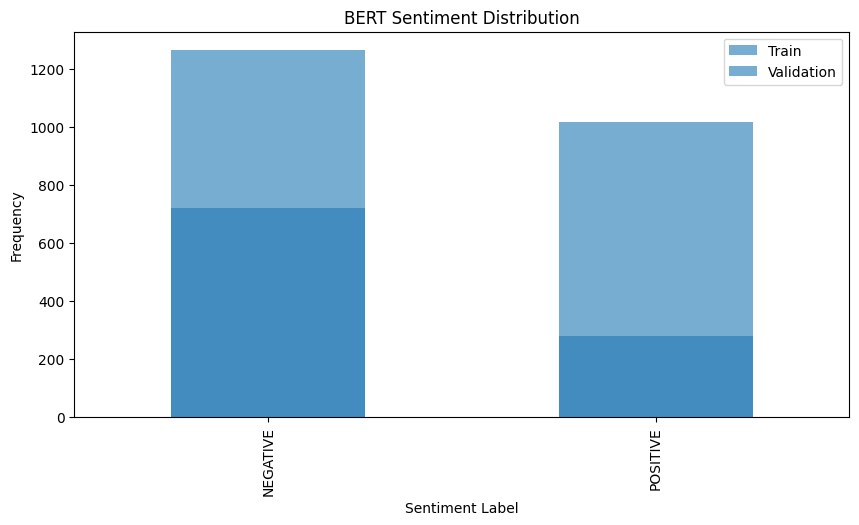

In [16]:
plt.figure(figsize=(10, 5))
train_data['bert_label'].value_counts().plot(kind='bar', alpha=0.6, label='Train')
validation_data['bert_label'].value_counts().plot(kind='bar', alpha=0.6, label='Validation')
plt.title('BERT Sentiment Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.show()